# LeNet
## 一、组成部分
 * 卷积编码器：两个$ kennel size \in R^{5*5} and paddings == 2$
 * 池化层：两个avgpooling ，stride=2
 * 全连接层密集块： 三个全连接层，分别为 $ \in R1^{400*120} and \in R2^{120*84} and \in R3^{84*10} $

![avatar](https://zh.d2l.ai/_images/lenet.svg)




In [1]:
import torch
from torch import nn

LeNet=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*25,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10)
)

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in LeNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


e:\coding_setting\Miniconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 通过实验我们看出，第一层的卷积层padding=2,则根据 $C_o=C_i-K+p+1$ 可得padding为2时可以抵消卷积层带来的部分参数缺失 **(p=padding*2)**
- 每一个池化层目的是使高度宽度都减半，汇聚参数特征
- 最后通过全连接层逐渐减少维数

In [2]:
# classification文件提供的针对图像分析的工具类函数
import torch
from torch.utils import data
import torchvision
from torch import nn
class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def clear(self):
        self.data=[0.0]*(len(self.data))
    #方便该类可以通过下标方式访问,如a[1]
    def __getitem__(self,i):
        return self.data[i]

def get_data_fashion_mnist(batch_size,loaders=0):
    mnist_train=torchvision.datasets.FashionMNIST(
        root='../data',train=True,download=True,transform=torchvision.transforms.ToTensor())
    mnist_test=torchvision.datasets.FashionMNIST(
        root='../data',train=False,download=True,transform=torchvision.transforms.ToTensor())
    return (data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=loaders)), \
           (data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=loaders)) 

def getAccuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())/y.shape[0]   

def evaluate_accuracy(net, data_iter):
    test_counter,test_acc=[],[]
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            X,y=X.to(device),y.to(device)
            metric.add(getAccuracy(net(X), y)*y.numel(), y.numel())
            test_acc.append(metric[0]/metric[1])
    test_counter=[i+1 for i in range(len(test_acc))]
    return metric[0] / metric[1],test_counter,test_acc

import matplotlib.pyplot as plt
class Graph:
    def __init__(self,xlabel,ylabel):
        self.fig=plt.figure()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    def addLine(self,x,y,color='black'):
        plt.plot(x,y,color=color)
    def addScatter(self,x,y,color='black'):
        plt.scatter(x,y,color=color)
    def addLegend(self,list,loc='upper right'):
        plt.legend(list,loc=loc)
    def show(self):
        plt.show()


In [3]:
batch_size=256
train_set,test_set=get_data_fashion_mnist(batch_size)
for X, y in train_set:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [4]:
from ctypes import sizeof


def init_weight(module):
    if(type(module)==nn.Linear or type(module)==nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)

def train(train_set,epochs,lr):
    net=LeNet
    optimizer=torch.optim.SGD(net.parameters(), lr=lr)
    loss=nn.CrossEntropyLoss()
    net.apply(init_weight)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    train_losses=[]
    train_counter=[]
    train_acc=[]
    for i in range(epochs):
        # 损失之和，准确率之和，总数
        metric=Accumulator(3)
        net.train()
        for X,y in train_set:
            X,y=X.to(device),y.to(device)
            optimizer.zero_grad()
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            metric.add(l*X.shape[0],getAccuracy(y_hat,y)*X.shape[0],X.shape[0])
            train_losses.append(l.item())
            train_acc.append(getAccuracy(y_hat,y))
        train_loss=metric[0]/metric[2]
        train_accuracy=metric[1]/metric[2]    
        print(f'第{i+1}次训练,损失为{train_loss},准确率为{train_accuracy}')
    ntest_acc,test_counter,test_acc=evaluate_accuracy(LeNet,test_set)
    print(f'该模型在测试集上的精度为{ntest_acc}')
    train_counter=[i+1 for i in range(len(train_losses))]
    g=Graph('num','loss or acc')
    g.addLine(train_counter,train_losses,'blue')
    g.addLine(train_counter,train_acc,'purple')
    g.addLine(test_counter,test_acc,'green')
    g.addLegend(['loss','acc'])
    g.show()


第1次训练,损失为1.1096767090479533,准确率为0.5915666666666667
第2次训练,损失为0.5539508808771769,准确率为0.7926666666666666
第3次训练,损失为0.4616067995071411,准确率为0.8272666666666667
第4次训练,损失为0.41800934874216716,准确率为0.8448
第5次训练,损失为0.3866628435134888,准确率为0.8561166666666666
该模型在测试集上的精度为0.8403


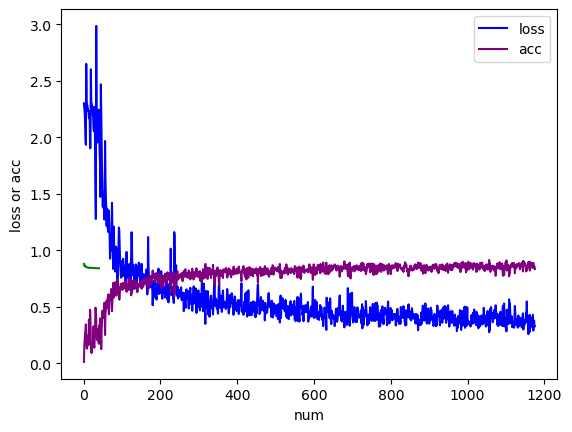

In [5]:
train(train_set,5 ,0.3)

> 第一次训练时发现并没有收敛，查找参数后发现是没有调到train模式，以下介绍不同模式的区别
> * **model.eval()**:不启用 BatchNormalization 和 Dropout。此时pytorch会自动把BN和DropOut固定住，不会取平均，而是用训练好的值。不然的话，一旦test的batch_size过小，很容易就会因BN层导致模型performance损失较大；
> * **model.train()**:启用 BatchNormalization 和 Dropout。 在模型测试阶段使用model.train() 让model变成训练模式，此时 dropout和batch normalization的操作在训练起到防止网络过拟合的问题。